In [145]:
import json
import math
import glob
import numpy as np
import pandas as pd

import keras_cv
import keras_tuner as kt
import keras
from keras import losses
from keras import optimizers
from keras import metrics

import tensorflow as tf
from tensorflow.keras.optimizers import schedules
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tf.test.is_gpu_available()

True

# Check Data Distribtion

In [3]:
train_files = glob.glob('/kaggle/input/cards-image-datasetclassification/train/**/*.jpg', recursive=True)
valid_files = glob.glob('/kaggle/input/cards-image-datasetclassification/valid/**/*.jpg', recursive=True)
test_files = glob.glob('/kaggle/input/cards-image-datasetclassification/test/**/*.jpg', recursive=True)

In [4]:
df_train = pd.DataFrame({
    "image_path":train_files
})

df_valid = pd.DataFrame({
    "image_path":valid_files
})

df_train[['split','class', 'image_name']] = df_train['image_path'].str.split('/', expand=True)[[4,5,6]]
df_valid[['split','class', 'image_name']] = df_valid['image_path'].str.split('/', expand=True)[[4,5,6]]

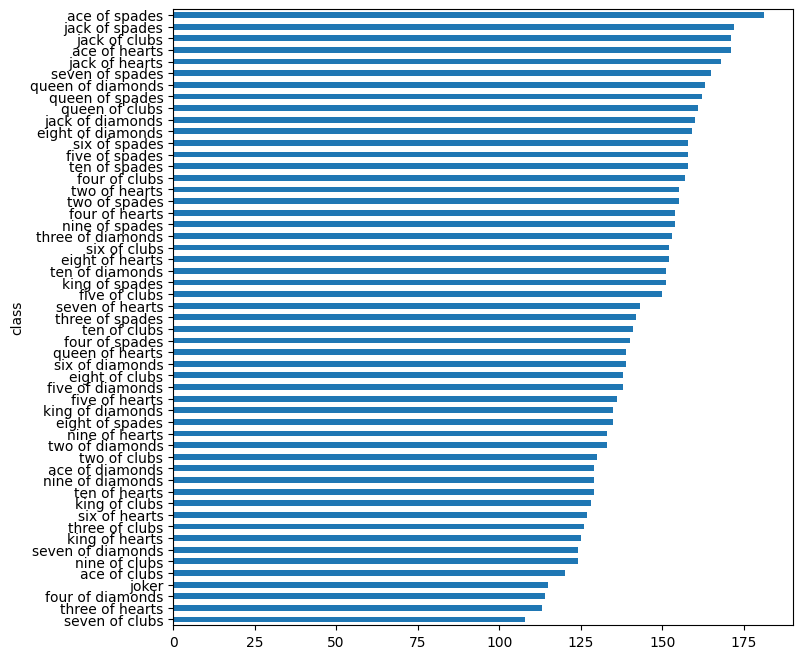

In [18]:
plt.figure(figsize=(8, 8))
df_train['class'].value_counts().sort_values().plot.barh();

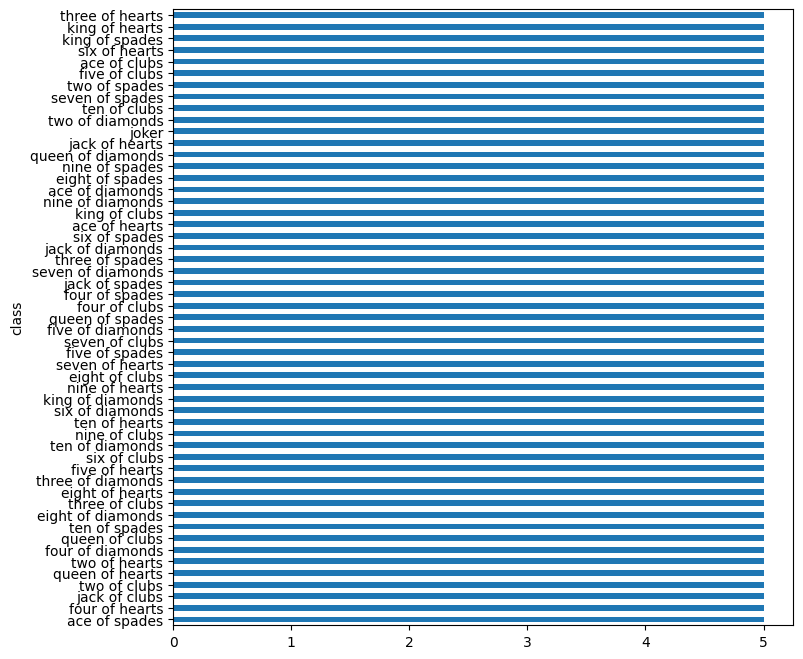

In [144]:
plt.figure(figsize=(8, 8))
df_valid['class'].value_counts().sort_values().plot.barh();

In [6]:
((df_train.groupby(['class'])['image_name'].count() / len(df_train['class'])) * 100 ).round(2).astype(str) + "%"

class
ace of clubs         1.57%
ace of diamonds      1.69%
ace of hearts        2.24%
ace of spades        2.37%
eight of clubs       1.81%
eight of diamonds    2.09%
eight of hearts      1.99%
eight of spades      1.77%
five of clubs        1.97%
five of diamonds     1.81%
five of hearts       1.78%
five of spades       2.07%
four of clubs        2.06%
four of diamonds      1.5%
four of hearts       2.02%
four of spades       1.84%
jack of clubs        2.24%
jack of diamonds      2.1%
jack of hearts        2.2%
jack of spades       2.26%
joker                1.51%
king of clubs        1.68%
king of diamonds     1.77%
king of hearts       1.64%
king of spades       1.98%
nine of clubs        1.63%
nine of diamonds     1.69%
nine of hearts       1.74%
nine of spades       2.02%
queen of clubs       2.11%
queen of diamonds    2.14%
queen of hearts      1.82%
queen of spades      2.12%
seven of clubs       1.42%
seven of diamonds    1.63%
seven of hearts      1.88%
seven of spades      2

In [7]:
batch_size = 32
img_height, img_width = 224, 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/cards-image-datasetclassification/train",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/cards-image-datasetclassification/valid",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


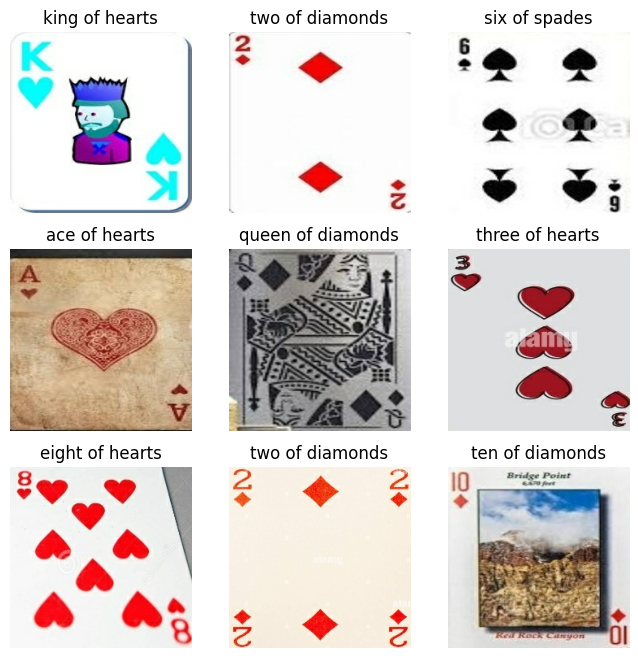

In [9]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
#     print(type(images[i].numpy().astype("uint8")))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Keras Model 

In [129]:
## simple model
# num_classes = len(train_ds.class_names)
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
#   layers.MaxPooling2D(pool_size=(2, 2)),
#   layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#   layers.MaxPooling2D(pool_size=(2, 2)),
#   layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#   layers.MaxPooling2D(pool_size=(2, 2)),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, activation="softmax")
# ])

In [132]:
num_classes = len(train_ds.class_names)

def create_en_model():
    backbone = keras_cv.models.EfficientNetV2B1Backbone()
    model = keras.Sequential(
        [
            backbone,
            keras.layers.GlobalMaxPooling2D(),
            keras.layers.Dropout(rate=0.5),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    return model


model = create_en_model()
model.summary()

In [135]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

epochs=50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/50


2023-11-26 13:55:49.588291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/efficient_net_v2_backbone_2/block1b_/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


239/239 [==============================] - 115s 262ms/step - loss: 1.8424 - accuracy: 0.4580 - val_loss: 1.1844 - val_accuracy: 0.6226
Epoch 2/50
239/239 [==============================] - 59s 248ms/step - loss: 1.7119 - accuracy: 0.4946 - val_loss: 1.0365 - val_accuracy: 0.6679
Epoch 3/50
239/239 [==============================] - 59s 247ms/step - loss: 1.4786 - accuracy: 0.5657 - val_loss: 0.8945 - val_accuracy: 0.7472
Epoch 4/50
239/239 [==============================] - 59s 247ms/step - loss: 1.3130 - accuracy: 0.6249 - val_loss: 0.8608 - val_accuracy: 0.7736
Epoch 5/50
239/239 [==============================] - 59s 247ms/step - loss: 1.1461 - accuracy: 0.6718 - val_loss: 0.8240 - val_accuracy: 0.7623
Epoch 6/50
239/239 [==============================] - 59s 247ms/step - loss: 1.0688 - accuracy: 0.6964 - val_loss: 0.7489 - val_accuracy: 0.7962
Epoch 7/50
239/239 [==============================] - 59s 248ms/step - loss: 0.9490 - accuracy: 0.7274 - val_loss: 0.7645 - val_accuracy: 0.

# Saving model

In [159]:
import os
import zipfile 
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'card_classifier.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [165]:
zip_dir(file_name="card_classifier_keras.zip")

/kaggle/working/card_classifier_keras.zip

In [153]:
!zip -r card_classifier.zip saved_model/card_classifier

  adding: saved_model/card_classifier/ (stored 0%)
  adding: saved_model/card_classifier/keras_metadata.pb (deflated 96%)
  adding: saved_model/card_classifier/fingerprint.pb (stored 0%)
  adding: saved_model/card_classifier/variables/ (stored 0%)
  adding: saved_model/card_classifier/variables/variables.index (deflated 77%)
  adding: saved_model/card_classifier/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/card_classifier/saved_model.pb (deflated 91%)
  adding: saved_model/card_classifier/assets/ (stored 0%)


In [164]:
!zip -r card_classifier_keras.zip card_classifier.keras

  adding: card_classifier.keras (deflated 7%)


In [166]:
ls

card_classifier.h5     card_classifier.zip        saved_model/
card_classifier.keras  card_classifier_keras.zip


In [149]:
!mkdir -p saved_model
model.save('saved_model/card_classifier')

In [162]:
model.save('card_classifier.keras')

# Visualize train/valid accuracy and loss

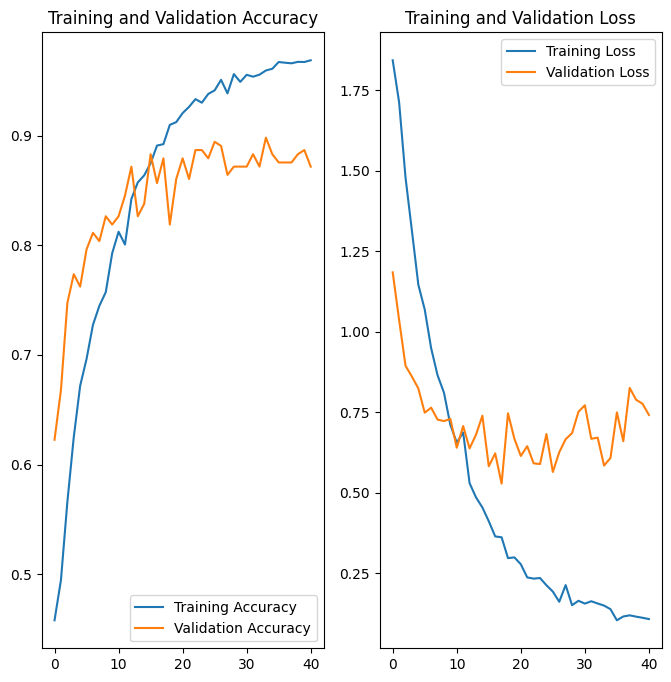

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation using test data

In [137]:
from sklearn.metrics import confusion_matrix, classification_report

In [138]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/cards-image-datasetclassification/test",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

y_test=[]
for _, label in test_ds:
    y_test.extend(label.numpy())

Found 265 files belonging to 53 classes.


In [139]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

9/9 [==============================] - 3s 62ms/step


In [140]:
indexx=2
pred_class = y_pred[indexx]
print(f"y_pred : {pred_class} | y_pred_class : {class_names[pred_class]} | y_test: {y_test[indexx]}")

y_pred : 5 | y_pred_class : eight of diamonds | y_test: 44


<Axes: >

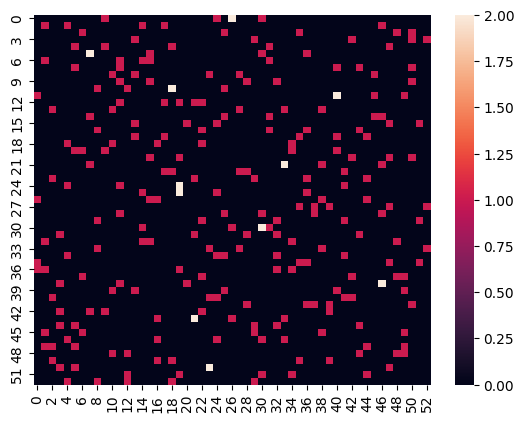

In [146]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [142]:
pd.DataFrame({
    'y_test':y_test,
    'y_pred':y_pred,
})

,y_test,y_pred
0,2,48
1,31,32
2,44,5
3,41,50
4,14,46
...,...,...
260,41,37
261,1,4
262,3,29
263,44,43


In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         5
          17       0.25    

# Inference new image

In [127]:
ls "/kaggle/input/cards-image-datasetclassification/test/ace of clubs"

1.jpg  2.jpg  3.jpg  4.jpg  5.jpg


1/1 [==============================] - 0s 90ms/step


'ace of clubs'

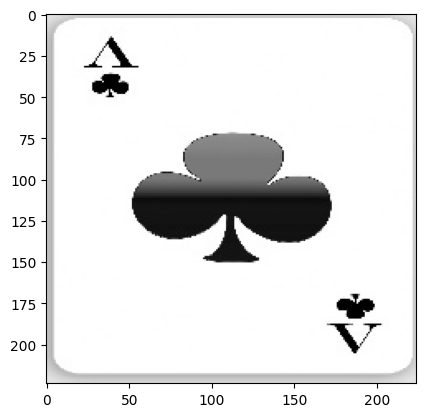

In [128]:
img = keras.utils.load_img(
    "/kaggle/input/cards-image-datasetclassification/test/ace of clubs/2.jpg", 
    target_size=(img_height, img_width)
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
class_names[np.argmax(predictions[0])]